# Model fitting

A model is an informative representation of an object, person or system. It is a way of describing the object or system in terms of its properties. The problem of model fitting is fundamental in computer vision and machine learning. It can be broken down into two parts:
- Fitting: find the parameters of a model that best fit the data
- Alignment: find the parameters of the transformation that best align matched points

A model can be as simple as a line or as complex as a 3D object. In this module we will see examples of fitting models to data, starting from a simple model type, known as edge image template and then moving to more complex models.

This module will be divided into three parts:

- [Part 1: Template matching](#tmpl_matching)
- [Part 2: Templage-based face detection](#face_detect)
- [Part 3: PCA-based face recognition](#face_recog)

## <a id='tmpl_matching'>Part 1: Template matching</a>

What is a Template? A template is an example of how an object looks.

Template matching is a technique in digital image processing for finding small parts of an image which match a template image or a patch. The goal of template matching is to find the patch/template in an image. To find it, the user has to give two input images: Source Image (S) – The image to find the template in, and a Template Image (T) – The image that is to be found in the source image. It is basically a method for searching and finding the location of a template image in a larger image.
    
How does Template Matching Work?
- The template image simply slides over the input image (as in 2D convolution)
- The template and the patch of input image under the template image are compared.
- The result obtained is compared with the threshold.
- If the result is greater than the threshold, the portion will be marked as detected.
- In the function `cv2.matchTemplate(img_gray,template,cv2.TM_CCOEFF_NORMED)` the first parameter is the mainimage, the second parameter is the template to be matched and the third parameter is the method used for matching, in this case we use the normalized cross-correlation.

### Sample application

Let's consider a the mobile game "Clash of Clans" where the player has to tap on the elixir icon to collect it. Let's assume we want to create a program that will load the game and collect the elixir for us from time to time. To collect do so, the program needs to find the location of the elixir icon in the screen. That can easily be done using the template matching method.

In [32]:
# Necessary imports
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt

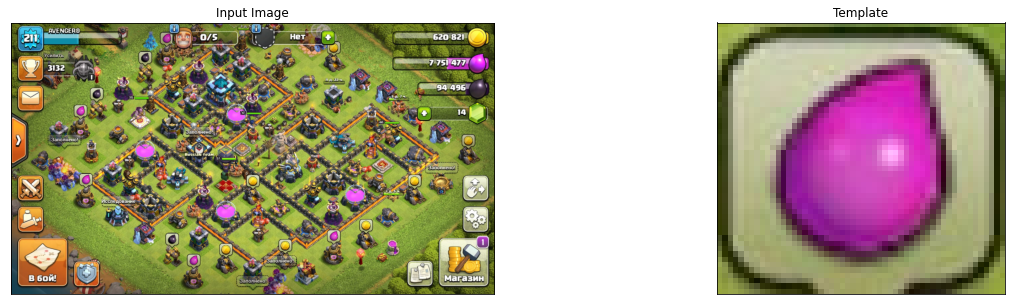

In [33]:
img = cv.imread('data/clash-of-clans-base.jpg')
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
template = cv.imread('data/elixir_pump_template.jpg')
template = cv.cvtColor(template, cv.COLOR_BGR2RGB)

# Display the images
plt.figure(figsize = (20,5))
plt.subplot(121), plt.imshow(img, cmap='gray')
plt.title('Input Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(template, cmap='gray')
plt.title('Template'), plt.xticks([]), plt.yticks([])
plt.show()

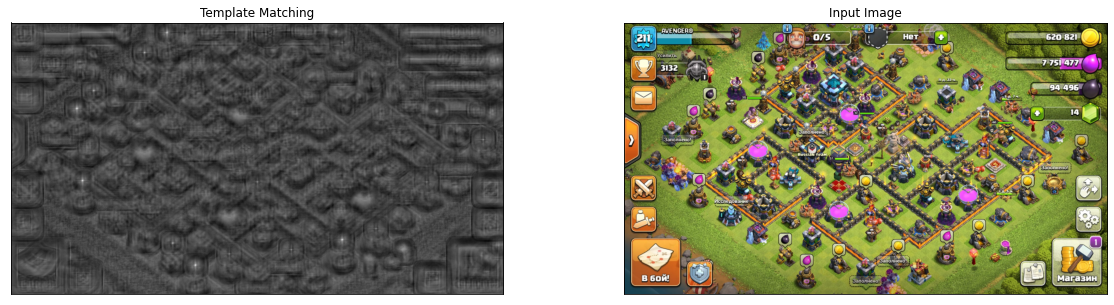

In [34]:
# Apply template Matching
result = cv.matchTemplate(img, template, cv.TM_CCOEFF_NORMED)

# Visualize the result
plt.figure(figsize = (20,5))
plt.subplot(121), plt.imshow(result, cmap='gray')
plt.title('Template Matching'), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(img, cmap='gray')
plt.title('Input Image'), plt.xticks([]), plt.yticks([])
plt.show()

In the template matching result avobe, the more white a pixel is the better the match of the top left corner of the template with that particular location in the image. Let's check what is the maximum value of the template matching result.

In [35]:
min_val, max_val, min_loc, max_loc = cv.minMaxLoc(result)

print(max_val)
print(max_loc)

0.9982191324234009
(698, 920)


We notice that the maximum value is around 0.998 and the location of the maximum value in the image is at pixel (698, 920). Let's go ahead a draw a white rectangle around the location of the best match.

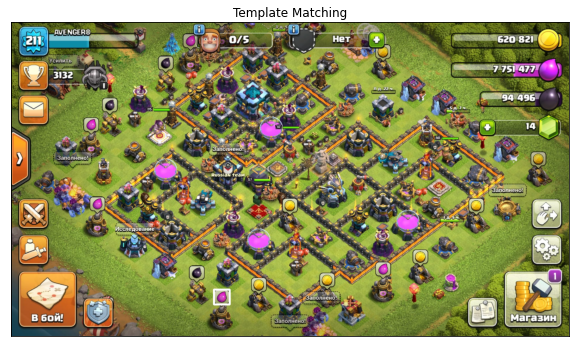

In [36]:
h, w, c = template.shape
top_left = max_loc
bottom_right = (top_left[0] + w, top_left[1] + h)
img = cv.rectangle(img, top_left, bottom_right, (255, 255, 255), 5)

# Display the image with a rectangle drawn on it
plt.figure(figsize = (10,15))
plt.imshow(img)
plt.title('Template Matching'), plt.xticks([]), plt.yticks([])
plt.show()

We can see the rectangle draw towards the bottom center of the image. The next question is, what if we want to detect not just the best match, but all the elixir icons in the image? To do so, we have to use a threhold.

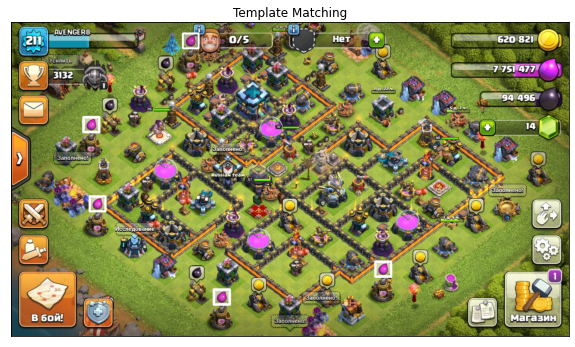

In [37]:
threshold = 0.8
loc = np.where( result >= threshold)
for pt in zip(*loc[::-1]):
    cv.rectangle(img, pt, (pt[0] + w, pt[1] + h), (255, 255, 255), 5)

# Display the image with a rectangle drawn on it
plt.figure(figsize = (10,15))
plt.imshow(img)
plt.title('Template Matching'), plt.xticks([]), plt.yticks([])
plt.show()

## <a id='face_detect'>Part 2: Template-based Face Detection</a>

In the previous example, the elixir icons that appear in the different locations of image are exact copies of the template. So, comparing them to the template using normalized cross-correlation will give us a result very close to 1.0 in all cases. Now, what if we want to use template matching to detect faces in an image? For simplicity we will only assume frontal views of faces. Different faces have more or less the same shape, but they also have differences, e.g. some people wear glasses, some people wear a hat, some people have a beard, etc. Using the face of a particular person as a template would probably work well for some people, but not for others. To create a template that is more likely to match most people, we can create an "average face" by taking the average multiple faces from a large dataset.

Let's load a few faces from our face dataset.

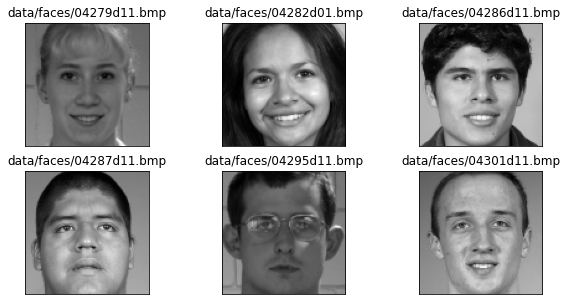

In [38]:
# Load faces dataset
filenames = [
    'data/faces/04279d11.bmp', 
    'data/faces/04282d01.bmp',
    'data/faces/04286d11.bmp',
    'data/faces/04287d11.bmp',
    'data/faces/04295d11.bmp',
    'data/faces/04301d11.bmp'
    ]

# Load images
images = [cv.imread(filename,cv.IMREAD_GRAYSCALE) for filename in filenames]

# Display the images
plt.figure(figsize = (10,5))
for i in range(len(images)):
    plt.subplot(2,3,i+1), plt.imshow(images[i], cmap='gray')
    plt.title(filenames[i]), plt.xticks([]), plt.yticks([])
plt.show()

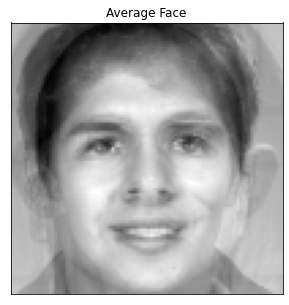

In [39]:
# Computer average face
average_face = np.zeros((images[0].shape[0], images[0].shape[1]))
for image in images:
    average_face += image
average_face /= len(images)

# Display the average face
plt.figure(figsize = (5,5))
plt.imshow(average_face, cmap='gray')
plt.title('Average Face'), plt.xticks([]), plt.yticks([])
plt.show()


The image above is the average of six faces from our dataset. Now let's compute the average face from all 337 faces in the dataset.

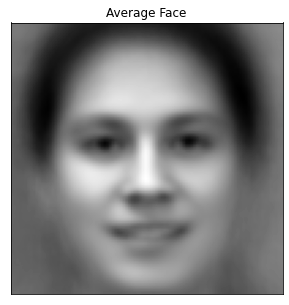

In [40]:
# Load all images in the folder data/faces
import os
filenames = [ 'data/faces/' + filename for filename in os.listdir('data/faces') ]
images = [cv.imread(filename,cv.IMREAD_GRAYSCALE) for filename in filenames]

# Computer average face
average_face = np.zeros((images[0].shape[0], images[0].shape[1]))
for image in images:
    average_face += image
average_face /= len(images)

# Display the average face
plt.figure(figsize = (5,5))
plt.imshow(average_face, cmap='gray')
plt.title('Average Face'), plt.xticks([]), plt.yticks([])
plt.show()


The original size of the face images is 100x100 pixels. To increase the likelihood of a match, we will further crop the template and keep the parts of the average face that are most likely to be present in all faces:
- Exclude background.
- Exclude forehead (highly variable appearance, due to hair).
- Exclude lower chin.

(60, 50)


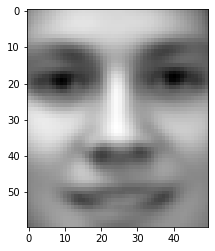

In [41]:
# Crop the average face to a square of size 60x50
average_face = average_face[25:85, 25:75]
print(average_face.shape)

plt.imshow(average_face, cmap='gray')    

We can now use the average face template to detect faces in the image. Before we do so, we need to solve one more problem. Our template is of shape (61, 50) pixels. Therefore it can only work well for faces that are of the same size. It could also be that the faces are not in exactly the upright position. To solve this problem, we need to resize the template to different scales and will also rotate it to different orientations.

In [42]:
# Auxiliary function to rotate an image
def rotate(image, angle, center = None):
    (h, w) = image.shape[:2]

    if center is None:
        center = (w / 2, h / 2)

    # Perform the rotation
    M = cv.getRotationMatrix2D(center, angle, scale = 1.0)
    rotated = cv.warpAffine(image, M, (w, h))

    return rotated

Implementation of a multi-scale, multi-orientation template matching algorithm.

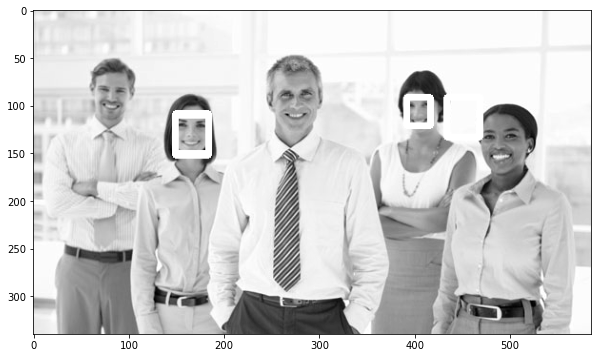

In [43]:


img = cv.imread('data/faces.jpg')
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)

img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
average_face = average_face.astype(np.uint8)


# Loop over scales and rotations of the average face template
for scale in np.arange(0.5, 1.5, 0.1):  # Scales
    scaled_avg_face = cv.resize(average_face, None, fx = scale, fy = scale)

    for angle in np.arange(-15, 15, 5):  # Rotate the average face from -15 to 15 degrees
        scaled_and_rotated_avg_face = rotate(scaled_avg_face, angle)
        h, w = scaled_and_rotated_avg_face.shape

        result = cv.matchTemplate(img_gray, scaled_and_rotated_avg_face, cv.TM_CCOEFF_NORMED)
        
        # Specify a threshold
        threshold = 0.6
        # Find the location of the best match
        loc = np.where( result >= threshold)

        for pt in zip(*loc[::-1]):
            # print(scale, pt)
            cv.rectangle(img_gray, pt, (pt[0] + w, pt[1] + h), 255, 5)

plt.figure(figsize = (10,15))
plt.imshow(img_gray, cmap='gray')
plt.show()


We notice that with a threshold of 0.6 only two of the faces are detected. If we lower the threshold, we will likely detect more faces, but will also probably get false positives, i.e. areas of the image that are not faces will be detected as faces. 

Normalized cross-correlation is a good method to detect for detecting objects that are stable in their appearance. Although faces can be detected with this method, it is not the best face detection method. In future modules we will see how to use other methods to detect faces.

## <a id='face_recog'>Part 3: PCA-based Face Recognition</a>

[Principal Component Analysis (PCA)](https://en.wikipedia.org/wiki/Principal_component_analysis) a statistical procedure to convert a set of observations of possibly correlated variables into a set of values of linearly uncorrelated variables. Each of the principal components is chosen in such a way that it would describe most of the still available variance and all these principal components are orthogonal to each other.

For example, in the image below, there is a collection of data points that are made up of two features, Feature 1 and Feature 2. The red arrow is parallel to the first principal component, which also the direction of the highest variance. The green arrow is parallel to the second principal component, and it is the direction of highest variance orthogonal to the first one. 

![PCA eigenvectors](img/pca_eigen.png)

After calculating the principal components, we can use them to transform the data into a new space. The new space is a subspace of the original space, where the first principal component is the direction of the highest variance. The second principal component is the direction of the highest variance orthogonal to the first one. The third principal component is the direction of the highest variance orthogonal to the first two, and so on. In this new space we can drop a dimension of low variance, and project the data points to the remaining dimensions. By only dropping dimensions of low variance, we can reduce the dimensionality of the data, while still retaining the majority of the information.

![PCA project](img/pca-projection.png)

Effectively, we can use the projection matrix of eigenvectors computed by PCA to represent high dimensional data in a low dimensional space, and we can use the eigenvectors to transform the data back to the original space. During this transformation process some information is lost, so the reconstructed data are not exactly the same as the original data, but they are close.

Let's now dive into how PCA works.

- **Step 1:** Load a set of face images and convert the images to vectors. The vectors are the data points that are used to compute the PCA. To convert a 2D grayscale image of dimensions H-by-W to a vector, we can simply take the pixels of the image and convert them to a 1D array of length M = H*W, by concatenating all the rows of the image horizontally.
- **Step 2:** Compute the mean of the vectors. The mean is the average of all the vectors. Normalize the vectors by subtracting the mean from each vector.
- **Step 3:** Compute the covariance matrix. The covariance matrix is a matrix that contains the covariance of each pair of vectors. The covariance of two vectors is the dot product of the difference between the two vectors and mean vector. The covariance matrix is a M-by-M matrix, where M is the dimensionality of the vectors.
- **Step 4:** Compute the eigenvectors and eigenvalues of the covariance matrix. The eigenvectors are unit vectors that point in the same directions as the principal components of the data, and the eigenvalues are the variances of the principal components.
- **Step 5:** Project the data onto the principal components. The projection of a vector x onto a set of principal components is the dot product of x and the eigenvectors corresponding to the largest eigenvalues.
- **Step 6:** Reconstruct the data from the projected data. The reconstructed data is the sum of the back-projected data and the mean.

In [44]:
# Step 1: Load the images and convert them to vectors
import os
filenames = [ 'data/faces/' + filename for filename in os.listdir('data/faces') ]

face_vectors = []
for filename in filenames:
    img = cv.imread(filename, cv.IMREAD_GRAYSCALE)
    img = img[25:85, 25:75]  # Crop the face

    img_vector = img.flatten() # Convert image to a column vector
    face_vectors.append(img_vector) # Add the vector to the list


# Convert the face vectors to a numpy array
face_vectors = np.column_stack(face_vectors)

# Step 2: Compute the average face vector
average_face_vector = np.mean(face_vectors, axis = 1)

# Convert dimensionality from (3000,) to (3000, 1) to allow matrix multiplication
average_face_vector = average_face_vector[:, np.newaxis] 

# Normalize each face vector by subtracting the average face vector
face_vectors_normalized = face_vectors - average_face_vector

# Step 3: Compute the covariance matrix
covariance_matrix = np.cov(face_vectors_normalized, rowvar = True)

# Step 4: Compute the eigenvectors and eigenvalues
eigenvalues, eigenvectors = np.linalg.eigh(covariance_matrix)

We have now computed the eigenvectors and eigenvalues of the covariance matrix. We can now use the eigenvectors to project the data onto the principal components. Before we do so, let's first visualize the top 10 (most significant) eigenvectors to see what they look like. Those will resemble faces. Each one of the eigenvectors captures some property of the face. If, on the other hand, we visualize the bottom 10 (least significant) eigenvectors, we will mostly appear as noise. To visualize the eigenvectors we reshape them back to 2D images. Those images also known as **eigenfaces**.

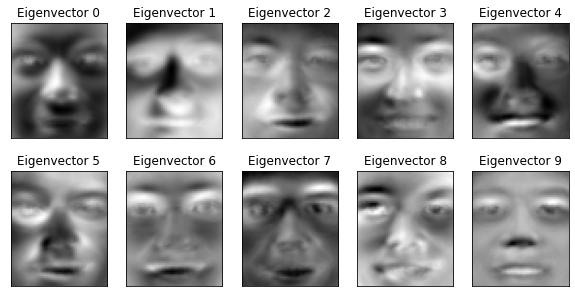

In [45]:
# Sort the eigenvectors and eigenvalues in descending order of eigenvalues
idx = eigenvalues.argsort()[::-1]
eigenvalues = eigenvalues[idx]
eigenvectors = eigenvectors[:, idx]

# Visualize the top 10 eigenvectors
plt.figure(figsize = (10,5))
for i in range(10):
    plt.subplot(2,5,i+1), plt.imshow(eigenvectors[:,i].reshape(60,50), cmap='gray')
    plt.title("Eigenvector " + str(i)), plt.xticks([]), plt.yticks([])
plt.show()

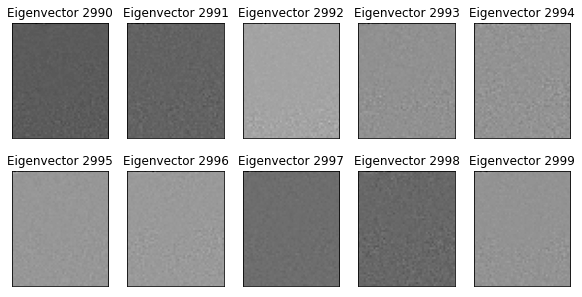

In [46]:
# Visualize the bottom 10 eigenvectors
plt.figure(figsize = (10,5))
for i in range(10):
    index = eigenvectors.shape[1] - (10 - i)
    plt.subplot(2,5,i+1), plt.imshow(eigenvectors[:, index].reshape(60,50), cmap='gray')
    plt.title("Eigenvector " + str(index)), plt.xticks([]), plt.yticks([])
plt.show()

Let's now see how we can reduce the dimensionality of a face image by projecting it onto a few principal components. We will start by projecting the face to only the **first principal component**.

In [47]:
face_vector = face_vectors[:, 40] # Select a random face vector

# Convert from (3000,) to (3000, 1) to allow matrix multiplication
face_vector = face_vector[:, np.newaxis]

# Normalize the face vector by subtracting the average face vector
face_vector_normalized = face_vector - average_face_vector

num_of_eigenvectors = 1     # Number of eigenvectors to use

# Project the face vector onto the eigenvectors to get the feature vector
# To project we compute the dot product of the transpose of the eigenvectors and the face vector
projected_face = (eigenvectors[:, :num_of_eigenvectors].T).dot(face_vector_normalized)

print('Projected face: ', projected_face)

Projected face:  [[1022.83769078]]


As we can see, the result of projecting a face to the first principal component is a scalar number. That is expected as the dot product of two matrices of shapes (1, 3000) x (3000, 1) is a matrix of dimension (1, 1), or scalar. Effectively, we are approximating the face with a single number. Let's now try to reconstruct the face by back-projecting it to its original shape. To do so, we need to multiply the projected data by the first eigenvector and add the mean.

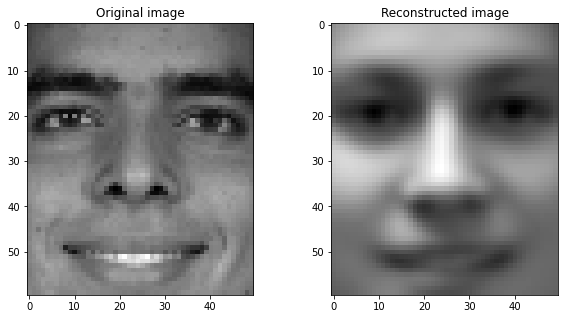

In [48]:
reconstructed_face_vector = (eigenvectors[:, :num_of_eigenvectors]).dot(projected_face) + average_face_vector

# Visualize the reconstructed face
face = face_vector.reshape(60, 50)
reconstructed_face = reconstructed_face_vector.reshape(60, 50)

plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.imshow(face, cmap='gray'), plt.title('Original image')
plt.subplot(122)
plt.imshow(reconstructed_face, cmap='gray'), plt.title('Reconstructed image')
plt.show()

As you can see, when using only one principal component, the reconstructed looks more like the average face than the original face. Let's try the same, but this time use the **first 10 principal components**.

In [49]:
num_of_eigenvectors = 10     # Number of eigenvectors to use

projected_face = (eigenvectors[:, :num_of_eigenvectors].T).dot(face_vector_normalized)

print(projected_face)

[[1022.83769078]
 [1132.96694613]
 [  46.05912337]
 [-503.05023283]
 [  72.37298782]
 [ 121.63619408]
 [-472.11375911]
 [ -84.60174625]
 [ 141.26829497]
 [ 284.75625669]]


Now the projected face is approximated by 10 numbers. Let's try to reconstruct the face by back-projecting it to its original shape.

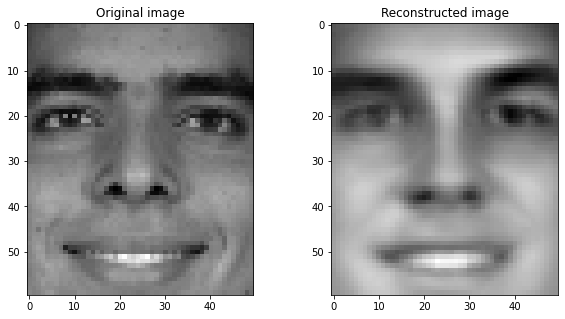

In [50]:
reconstructed_face_vector = (eigenvectors[:, :num_of_eigenvectors]).dot(projected_face) + average_face_vector

# Visualize the reconstructed face
face = face_vector.reshape(60, 50)
reconstructed_face = reconstructed_face_vector.reshape(60, 50)

plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.imshow(face, cmap='gray'), plt.title('Original image')
plt.subplot(122)
plt.imshow(reconstructed_face, cmap='gray'), plt.title('Reconstructed image')
plt.show()

It's now starting to look more like the original face. Let's try the same, but this time use the first 100 principal components.

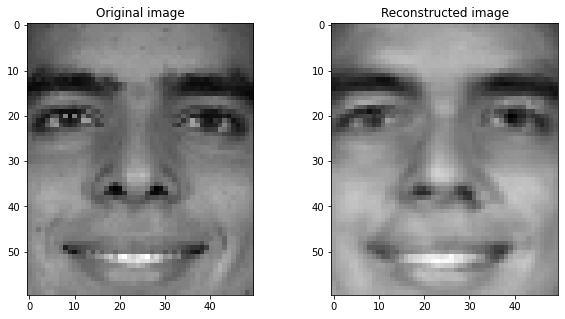

In [51]:
num_of_eigenvectors = 100     # Number of eigenvectors to use

projected_face = (eigenvectors[:, :num_of_eigenvectors].T).dot(face_vector_normalized)

reconstructed_face_vector = (eigenvectors[:, :num_of_eigenvectors]).dot(projected_face) + average_face_vector

# Visualize the reconstructed face
face = face_vector.reshape(60, 50)
reconstructed_face = reconstructed_face_vector.reshape(60, 50)

plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.imshow(face, cmap='gray'), plt.title('Original image')
plt.subplot(122)
plt.imshow(reconstructed_face, cmap='gray'), plt.title('Reconstructed image')
plt.show()

200 Principal Components

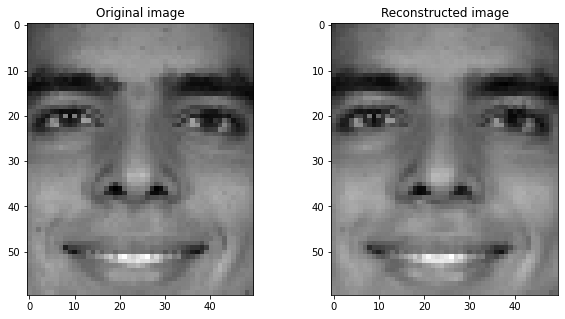

In [52]:
num_of_eigenvectors = 200     # Number of eigenvectors to use

projected_face = (eigenvectors[:, :num_of_eigenvectors].T).dot(face_vector_normalized)

reconstructed_face_vector = (eigenvectors[:, :num_of_eigenvectors]).dot(projected_face) + average_face_vector

# Visualize the reconstructed face
face = face_vector.reshape(60, 50)
reconstructed_face = reconstructed_face_vector.reshape(60, 50)

plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.imshow(face, cmap='gray'), plt.title('Original image')
plt.subplot(122)
plt.imshow(reconstructed_face, cmap='gray'), plt.title('Reconstructed image')
plt.show()

Now the reconstructed face looks much more like the original face. What this shows us is that we can reduce the dimensionality of the face image from 3000 to 200 or 100 and still retain most of the information.

Next, let's bundle the PCA code that we have written into functions, so that we can easily reuse them.

In [53]:
# A function that computes the PCA of a set of vectors
def computePCA(data_vectors, average_vector, n_components):
    if n_components > min(data_vectors.shape[1], data_vectors.shape[1]):
        print('Number of components must be less than or equal  to the smallest between number of features and number of samples')
        print("Setting number of components to", min(data_vectors.shape[1], data_vectors.shape[1]))
        n_components = min(data_vectors.shape[1], data_vectors.shape[1])

    # Normalize each face vector by subtracting the average face vector
    data_vectors_normalized = data_vectors - average_vector

    # Compute the eigenvectors and eigenvalues
    covariance_matrix = np.cov(data_vectors_normalized, rowvar = True)

    # Step 4: Compute the eigenvectors and eigenvalues
    eigenvalues, eigenvectors = np.linalg.eigh(covariance_matrix)

    # Sort the eigenvectors and eigenvalues in descending order of eigenvalues
    idx = eigenvalues.argsort()[::-1]
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]

    return eigenvectors[:, :n_components]

# A function that projects a set of vectors onto a set of eigenvectors
def pca_project(data_vectors, eigenvectors, average_vector):
    data_vectors_normalized = data_vectors - average_vector
    return eigenvectors.T.dot(data_vectors_normalized)

# A function that reconstructs a set of vectors from a set of eigenvectors
def pca_reconstruct(projected_data, eigenvectors, average_vector):
    # Reconstruct the data
    return eigenvectors.dot(projected_data) + average_vector

### Face recognition using PCA

The face recognition algorithm using PCA is implemented as follows:
- 1. Create a dataset of a few face image samples of each person that we want to recognize. We will call this the **training set**.
- 2. Compute the PCA of the training set.
- 3. Project the training set onto the PCA. This will effectively project each face image in our training set onto a subspace of lower dimension.
- 4. For every new face (**test face**) that we want to recognize, project the test face onto the same subspace as the training set.
- 5. Find the closest match to the projected face by comparing the subspace vector distance between the test face and training set faces.

The idea is that the test face is more likely to be closer to a face image in the training set that came from the same person. By projecting the faces to a lower dimensional subspace, we can reduce the dimensionality of the faces and thus the amount of information that we need to store in the database. This allows us to store less information in the database, which can make it more efficient and faster to search for faces in the database. The downside is that we lose some information when we reduce the dimensionality of the faces. However, that can also be an advantage, as the the lost information is more likely to be details that differ from between different image samples of the same person. Features that are constant across different images of the same person will likely be considered as important and be retained in the top eigenvectors.

In this example, we will create a dataset of 10 people with 5 face images each. 

In [54]:
import os   # For listing the files in a directory

# Load training face data from 'data/face_recongition_db/train_data' folder
train_data_path = 'data/face_recongition_db/train_data'
train_data = []
train_labels = []
for dirname, dirnames, filenames in os.walk(train_data_path):
    for subdirname in dirnames:
        subject_path = os.path.join(dirname, subdirname)
        for filename in os.listdir(subject_path):
            if filename.endswith('.bmp'):
                subject_file_path = os.path.join(subject_path, filename)
                face_img = cv.imread(subject_file_path, cv.IMREAD_GRAYSCALE)
                face_img = face_img[25:85, 25:75]
                face_vector = face_img.flatten()
                face_vector = face_vector[:, np.newaxis]
                train_data.append(face_vector)
                train_labels.append(int(subdirname))

# Convert the face vectors to a numpy array
train_data = np.column_stack(train_data)

# Load training face data from 'data/face_recongition_db/test_data' folder
test_data_path = 'data/face_recongition_db/test_data'
test_data = []
test_labels = []
for dirname, dirnames, filenames in os.walk(test_data_path):
    for subdirname in dirnames:
        subject_path = os.path.join(dirname, subdirname)
        for filename in os.listdir(subject_path):
            if filename.endswith('.bmp'):
                subject_file_path = os.path.join(subject_path, filename)
                face_img = cv.imread(subject_file_path, cv.IMREAD_GRAYSCALE)
                face_img = face_img[25:85, 25:75]
                face_vector = face_img.flatten()
                face_vector = face_vector[:, np.newaxis]
                test_data.append(face_vector)
                test_labels.append(int(subdirname))

test_data = np.column_stack(test_data)

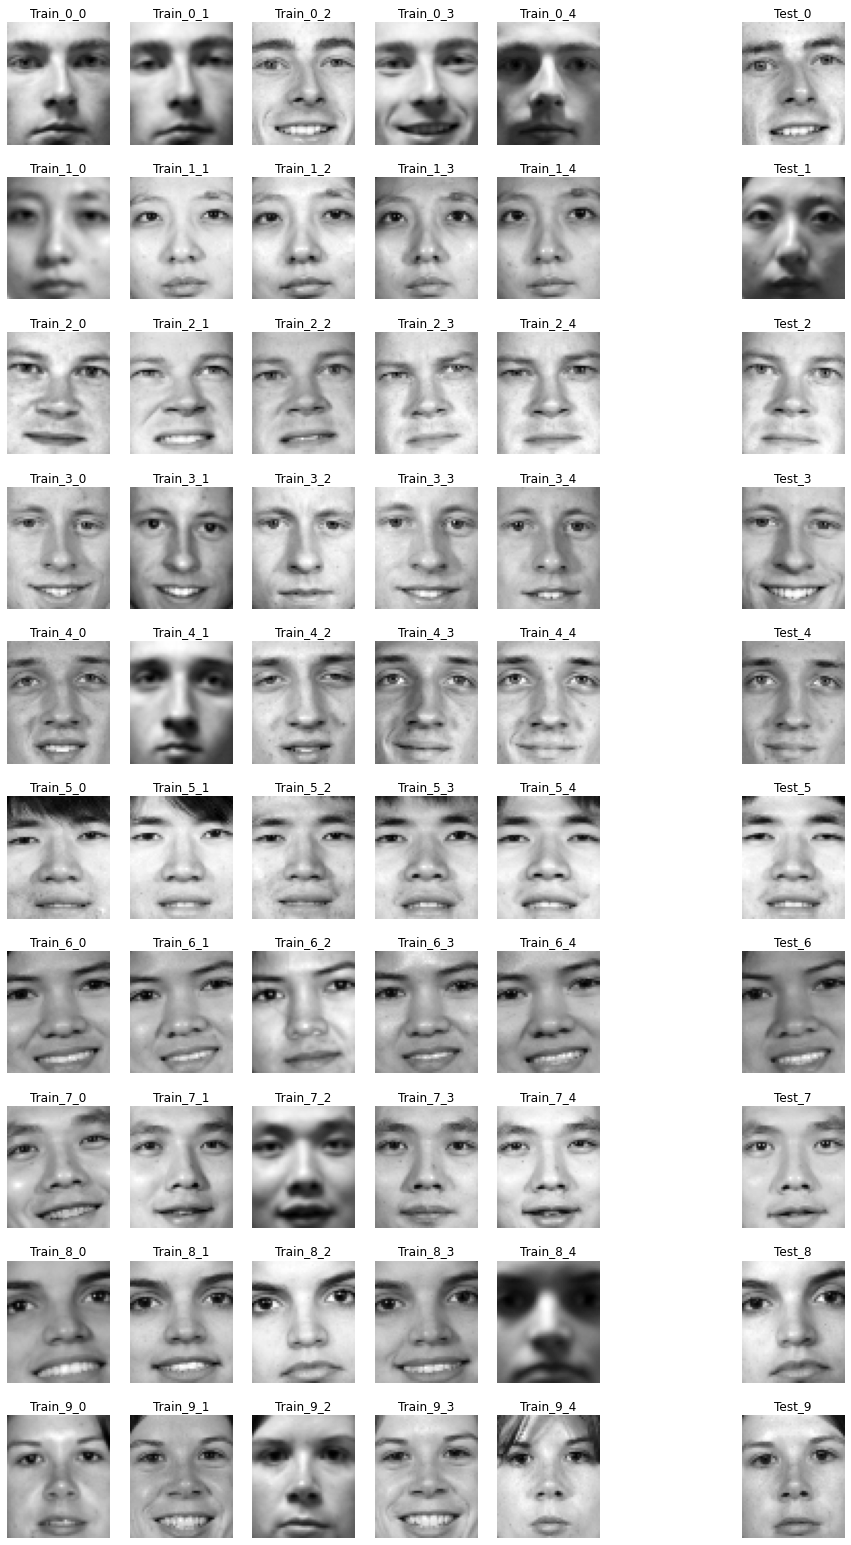

In [55]:
# Visualize the training and test data
plt.figure(figsize=(15, 28))
for i in range(10):
    for j in range(5):
        plt.subplot2grid((10, 7), (i, j))
        plt.imshow(train_data[:, i*5+j].reshape(60, 50), cmap='gray')
        plt.title('Train_' + str(i) + '_' + str(j)), plt.axis('off')
    plt.subplot2grid((10, 7), (i, 6))
    plt.imshow(test_data[:, i].reshape(60, 50), cmap='gray')
    plt.title('Test_' + str(i)), plt.axis('off')
plt.show()

Computer PCA on the training set.

In [56]:
average_vector = np.mean(train_data, axis=1)
average_vector = average_vector[:, np.newaxis]

# Compute PCA on the training data
eigenvectors = computePCA(train_data, average_vector, n_components=20)

# Project all training data onto the first 50 eigenvectors
train_data_projected = pca_project(train_data, eigenvectors, average_vector)

# Reconstruct the training data
train_data_reconstructed = pca_reconstruct(train_data_projected, eigenvectors, average_vector)

# # Display original and reconstructed training data for each training face (FOR DEBUGGING)

# print('Average face:')
# plt.imshow(average_vector.reshape(60, 50), cmap='gray')
# plt.show()

# for i in range(train_data_projected.shape[1]):
#     plt.subplot2grid((1, 2), (0, 0))
#     plt.imshow(train_data[:, i].reshape(60, 50), cmap='gray')
#     plt.title('Original_' + str(i)), plt.axis('off')
#     plt.subplot2grid((1, 2), (0, 1))
#     plt.imshow(train_data_reconstructed[:, i].reshape(60, 50), cmap='gray')
#     plt.title('Reconstructed_' + str(i)), plt.axis('off')
#     plt.show()
#     distance = np.linalg.norm(train_data[:, i] - train_data_reconstructed[:, i])
#     print("Distance: ", distance)

Classify test faces into one of the 10 people in the training set.

True label:  0 , Closest match:  14 , Predicted label:  2  distance:  921.6382534307388


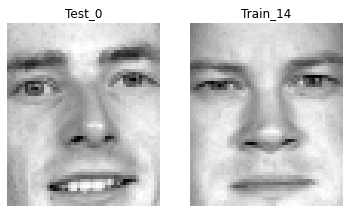

True label:  1 , Closest match:  37 , Predicted label:  7  distance:  1341.7341357246494


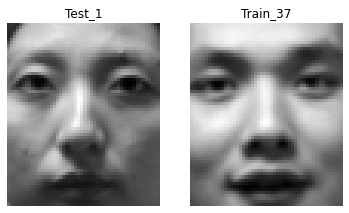

True label:  2 , Closest match:  13 , Predicted label:  2  distance:  888.8578453121265


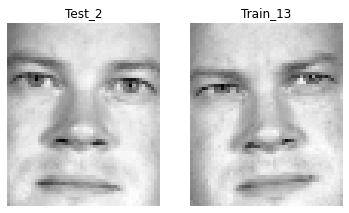

True label:  3 , Closest match:  17 , Predicted label:  3  distance:  836.1678914151985


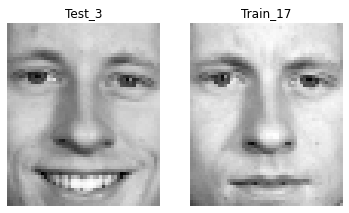

True label:  4 , Closest match:  24 , Predicted label:  4  distance:  869.4719583830654


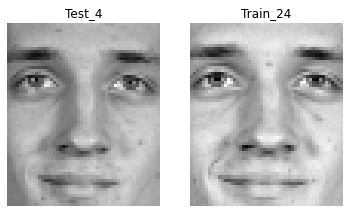

True label:  5 , Closest match:  29 , Predicted label:  5  distance:  910.2583768367602


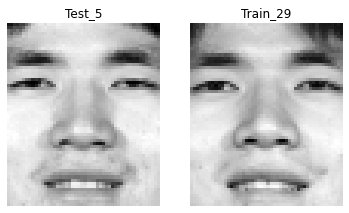

True label:  6 , Closest match:  35 , Predicted label:  7  distance:  1009.6142979133717


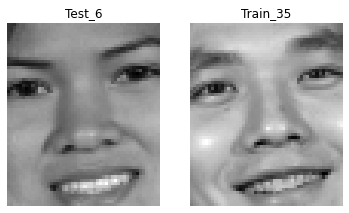

True label:  7 , Closest match:  6 , Predicted label:  1  distance:  897.6205147212979


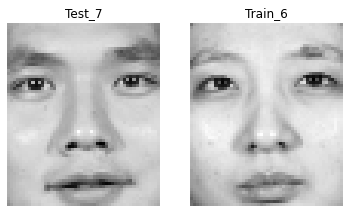

True label:  8 , Closest match:  41 , Predicted label:  8  distance:  1043.3655565087809


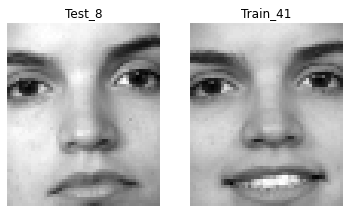

True label:  9 , Closest match:  45 , Predicted label:  9  distance:  762.4341432292345


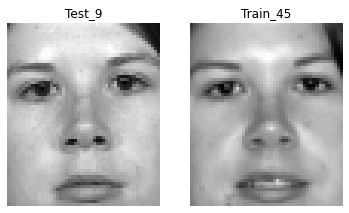

In [57]:
# For each face in the test set, find the closest match in the training set
# The distance between the test face and the training face is the Euclidean distance
# The Euclidean distance is the square root of the sum of the squares of the differences between the two vectors
for i in range(test_data.shape[1]):
    test_face_vector = test_data[:, i]
    test_face_vector = test_face_vector[:, np.newaxis]
    test_face_vector_projected = pca_project(test_face_vector, eigenvectors, average_vector)
    
    distances = np.sqrt(np.sum(np.square(train_data_projected - test_face_vector_projected), axis=0))
    min_index = np.argmin(distances)
    
    print("True label: ", i, ", Closest match: ", min_index, ", Predicted label: ", train_labels[min_index], " distance: ", distances[min_index])
    plt.subplot2grid((1, 2), (0, 0))
    plt.imshow(test_face_vector.reshape(60, 50), cmap='gray')
    plt.title('Test_' + str(i)), plt.axis('off')
    plt.subplot2grid((1, 2), (0, 1))
    plt.imshow(train_data[:, min_index].reshape(60, 50), cmap='gray')
    plt.title('Train_' + str(min_index)), plt.axis('off')
    plt.show()

As we can see, most of the test faces are classified into the same person as the training faces, but not all of them. PCA-based face recognition is not the most robust algorithm for face recognition, but it is a good way to demonstrate the power of PCA. Recently, much more accurate algorithms have been developed, based on Deep Learning methods.